Epoch 1/150


c:\Users\giang\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - loss: 0.0444 - mae: 0.1482 - val_loss: 0.0155 - val_mae: 0.0938
Epoch 2/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.0121 - mae: 0.0767 - val_loss: 0.0115 - val_mae: 0.0764
Epoch 3/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 0.0100 - mae: 0.0681 - val_loss: 0.0107 - val_mae: 0.0721
Epoch 4/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: 0.0092 - mae: 0.0630 - val_loss: 0.0095 - val_mae: 0.0654
Epoch 5/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - loss: 0.0085 - mae: 0.0598 - val_loss: 0.0132 - val_mae: 0.0873
Epoch 6/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - loss: 0.0089 - mae: 0.0621 - val_loss: 0.0105 - val_mae: 0.0726
Epoch 7/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - loss: 0.0077 - mae: 0.0559 - val_loss: 0.0088 - val_mae: 0.0616
Epoch 8/150
109/109 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.0079 - mae: 0.0575 - val_loss: 0.0089 - val_mae: 0.0635
Epoch 9/150
109/109 ━━━━━━━━━━━━━━━━━━━━

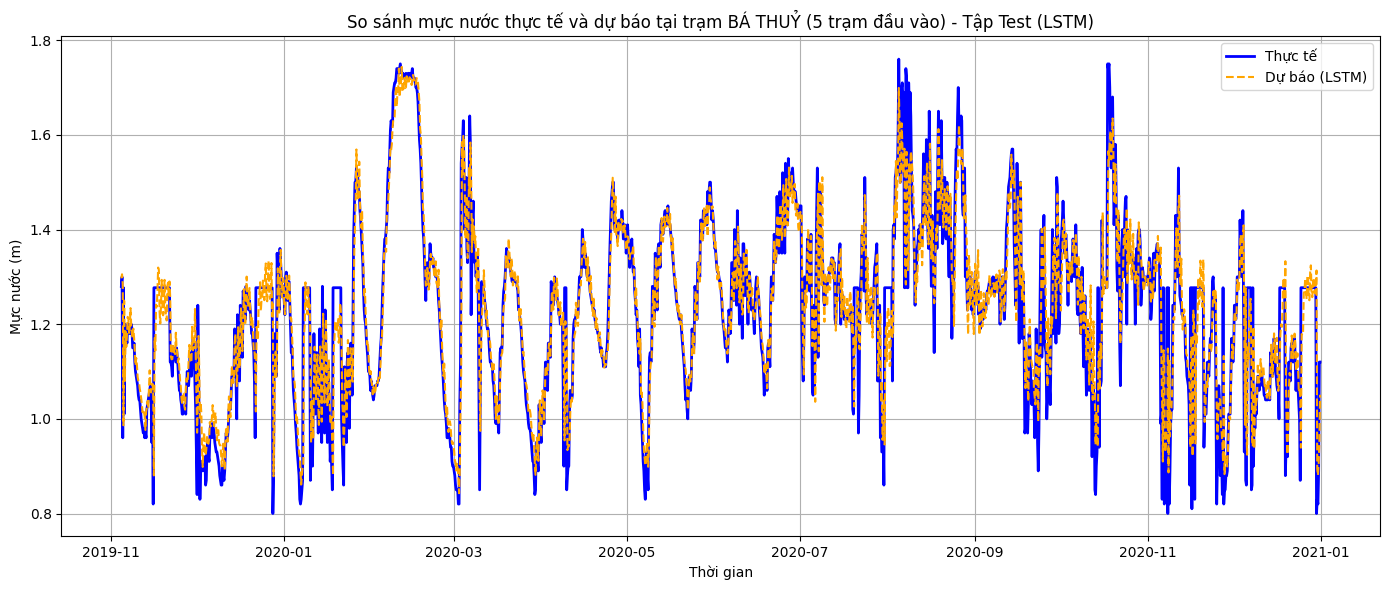

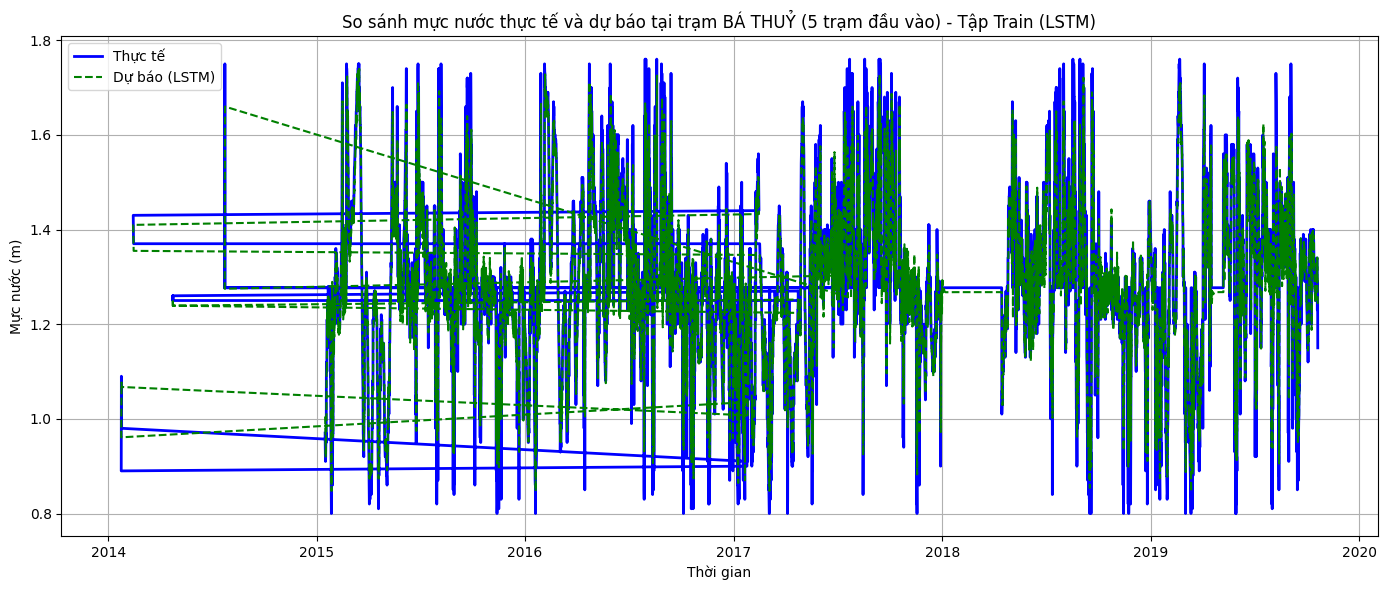

In [4]:
# Dự báo từ 5 trạm(1)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.callbacks import EarlyStopping
import joblib

# 1. Đọc dữ liệu
df = pd.read_excel("../Data/MN2015_2020_DoAn.xlsx")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

# Chọn các cột feature và target
feature_cols = ['X. QUAN', 'CẦU CẤT', 'CẦU XE', 'AN THỔ', 'LỰC ĐIỀN']
target_col = 'BÁ THUỶ'
dataset = df[feature_cols + [target_col]]

# 2. Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# 3. Chia tập train/test
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size:, :]

# 4. Tạo dataset với time steps
def create_dataset(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, :])  # Lấy tất cả các features
        y.append(data[i, -1])  # Chỉ lấy cột BÁ THỦY (cột cuối cùng)
    return np.array(X), np.array(y)

time_steps = 60
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape dữ liệu cho LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# 5. Xây dựng mô hình LSTM
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(time_steps, X_train.shape[2])),
    LSTM(64, return_sequences=False),
    Dense(32),
    Dense(16),
    Dense(1)  # Output 1 giá trị cho BÁ THỦY
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Thêm EarlyStopping để tránh overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# 6. Huấn luyện mô hình
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)


# Hàm chuẩn bị dữ liệu inverse transform
def inverse_transform(preds, original_data, scaler, feature_cols_len):
    temp = np.zeros((len(preds), feature_cols_len + 1))
    temp[:, -1] = preds.flatten()
    temp[:, :-1] = original_data[time_steps:, :-1]
    return scaler.inverse_transform(temp)[:, -1]

# --- Đánh giá trên tập test ---
predictions_test = model.predict(X_test)
predictions_test_inv = inverse_transform(predictions_test, test_data, scaler, len(feature_cols))
y_test_inv = inverse_transform(y_test.reshape(-1,1), test_data, scaler, len(feature_cols))

# --- Đánh giá trên tập train ---
predictions_train = model.predict(X_train)
predictions_train_inv = inverse_transform(predictions_train, train_data, scaler, len(feature_cols))
y_train_inv = inverse_transform(y_train.reshape(-1,1), train_data, scaler, len(feature_cols))

# Hàm đánh giá
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

mae_test, mse_test, rmse_test, r2_test = evaluate_model(y_test_inv, predictions_test_inv)
print("\nĐánh giá mô hình trên tập Test")
print(f"Test MAE: {mae_test:.4f}")
print(f"Test MSE: {mse_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test R2 Score: {r2_test:.4f}")


mae_train, mse_train, rmse_train, r2_train = evaluate_model(y_train_inv, predictions_train_inv)
print("\nĐánh giá mô hình trên tập Train")
print(f"Train MAE: {mae_train:.4f}")
print(f"Train MSE: {mse_train:.4f}")
print(f"Train RMSE: {rmse_train:.4f}")
print(f"Train R2 Score: {r2_train:.4f}")

# Trục thời gian cho tập test (bỏ đi 60 bước đầu)
dates_test = df.index[train_size + time_steps:]

plt.figure(figsize=(14, 6))
plt.plot(dates_test, y_test_inv, label='Thực tế', color='blue', linewidth=2)
plt.plot(dates_test, predictions_test_inv, label='Dự báo (LSTM)', color='orange', linestyle='--')
plt.title('So sánh mực nước thực tế và dự báo tại trạm BÁ THUỶ (5 trạm đầu vào) - Tập Test (LSTM)')
plt.xlabel('Thời gian')
plt.ylabel('Mực nước (m)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Trục thời gian cho tập train (cũng bỏ 60 bước đầu)
dates_train = df.index[time_steps:train_size]

plt.figure(figsize=(14, 6))
plt.plot(dates_train, y_train_inv, label='Thực tế', color='blue', linewidth=2)
plt.plot(dates_train, predictions_train_inv, label='Dự báo (LSTM)', color='green', linestyle='--')
plt.title('So sánh mực nước thực tế và dự báo tại trạm BÁ THUỶ (5 trạm đầu vào) - Tập Train (LSTM)')
plt.xlabel('Thời gian')
plt.ylabel('Mực nước (m)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
# Gộp dự đoán train + test
y_full_pred = np.concatenate([predictions_train_inv, predictions_test_inv])
y_full_true = np.concatenate([y_train_inv, y_test_inv])

# Do đã dùng time_steps, index bị lệch -> Lấy lại index đúng từ df (tính từ time_steps)
index_full = df.index[time_steps:]

# Do chỉ dùng 80% dữ liệu cho train, phần test cũng phải dịch thêm time_steps
# Tổng số dòng sau khi tạo dataset: len(train_data) + len(test_data) - 2*time_steps
total_samples = len(y_full_pred)
index_result = index_full[-total_samples:]

# Tạo DataFrame kết quả
df_result = pd.DataFrame({
    'Thời gian': index_result,
    'Giá trị thực tế': y_full_true,
    'Giá trị dự đoán': y_full_pred
}).set_index('Thời gian')

# Hiển thị vài dòng đầu
print("\nDữ liệu dự báo (Train + Test):")
print(df_result.head())

# Lưu ra file nếu cần
df_result.to_excel("../Data/du_bao_BA_THUY_LSTM_4Tram.xlsx")



Dữ liệu dự báo (Train + Test):
                     Giá trị thực tế  Giá trị dự đoán
Thời gian                                            
2015-01-31 01:00:00             0.97         1.003097
2015-01-31 07:00:00             0.93         0.988090
2015-01-31 13:00:00             0.92         0.960040
2015-01-31 19:00:00             0.91         0.942570
2015-02-01 01:00:00             0.92         0.927791


c:\Users\giang\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 0.0207 - mae: 0.1012 - val_loss: 0.0112 - val_mae: 0.0742
Epoch 2/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 0.0103 - mae: 0.0693 - val_loss: 0.0102 - val_mae: 0.0688
Epoch 3/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0088 - mae: 0.0596 - val_loss: 0.0092 - val_mae: 0.0625
Epoch 4/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 0.0085 - mae: 0.0572 - val_loss: 0.0086 - val_mae: 0.0568
Epoch 5/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0076 - mae: 0.0543 - val_loss: 0.0089 - val_mae: 0.0613
Epoch 6/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 0.0089 - mae: 0.0579 - val_loss: 0.0088 - val_mae: 0.0586
Epoch 7/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 0.0085 - mae: 0.0556 - val_loss: 0.0089 - val_mae: 0.0619
Epoch 8/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 0.0081 - mae: 0.0565 - val_loss: 0.0086 - val_mae: 0.0580
Epoch 9/100
218/218 ━━━━━━━━━━━━━━━━

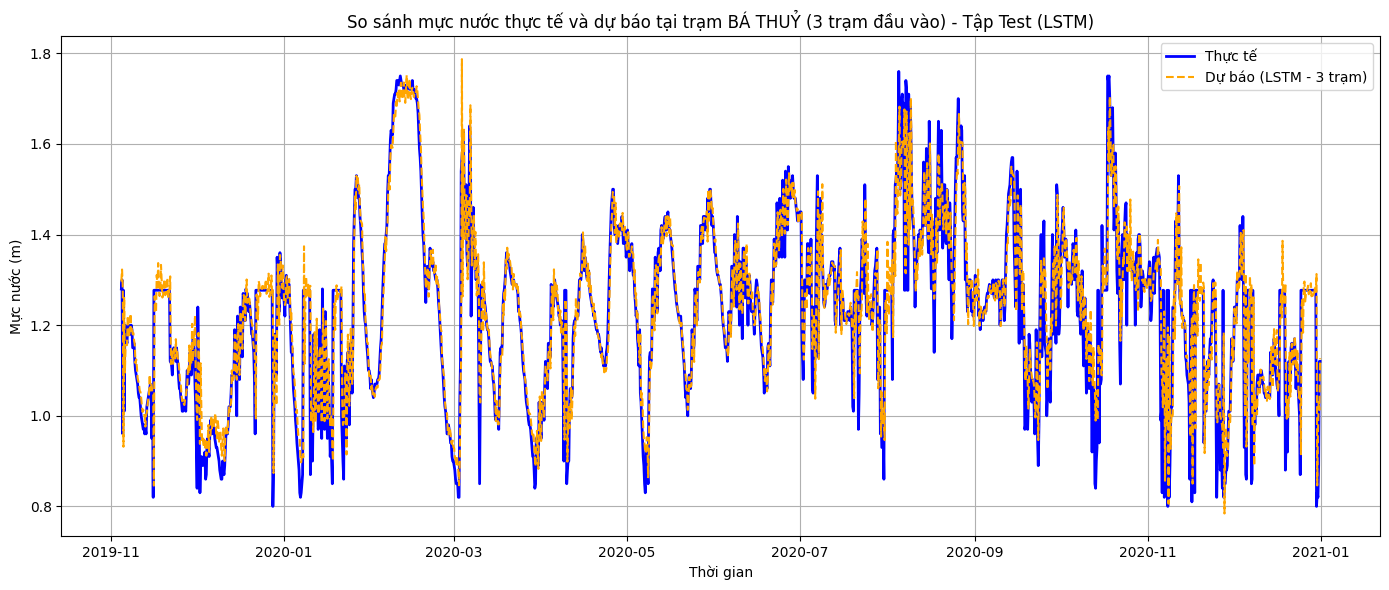

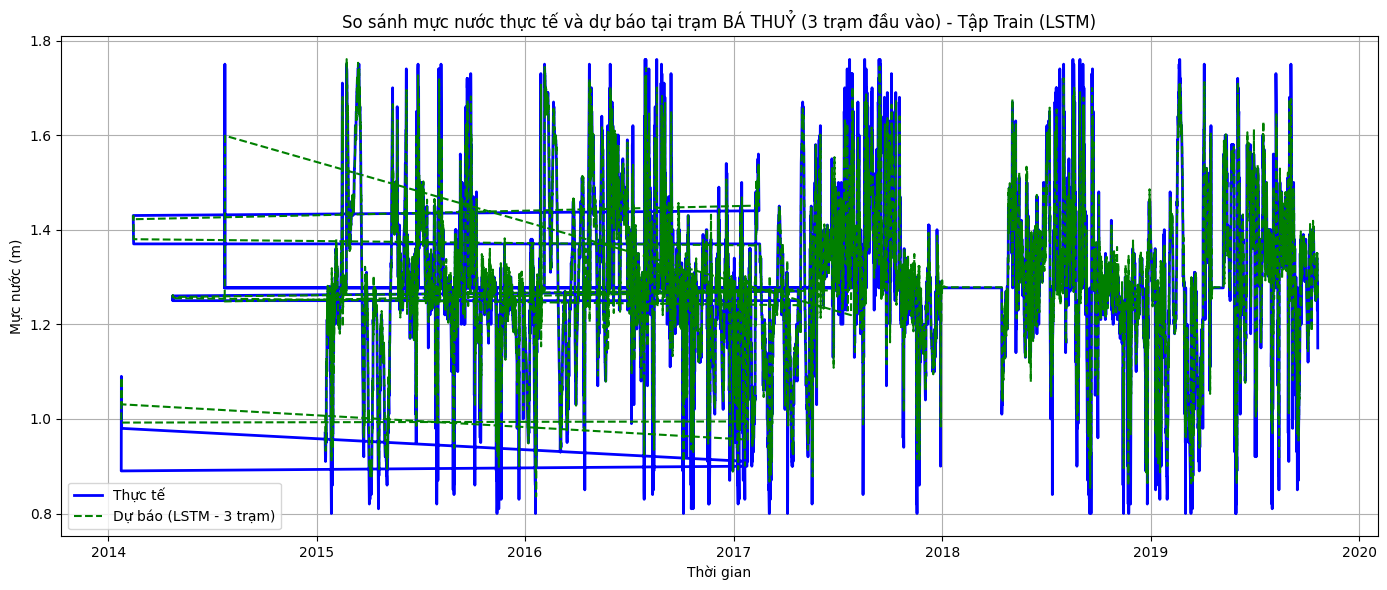

In [1]:
# Dự báo từ 3 trạm(2)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.callbacks import EarlyStopping

# Đọc dữ liệu
df = pd.read_excel("../Data/MN2015_2020_DoAn.xlsx")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

# Chọn các cột feature và target
feature_cols = ['CẦU CẤT', 'CẦU XE', 'AN THỔ']
target_col = 'BÁ THUỶ'
dataset = df[feature_cols + [target_col]]

# 2. Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# 3. Chia tập train/test
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size:, :]

# 4. Tạo dataset với time steps
def create_dataset(data, time_steps=60, n_features=4):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, :n_features])  # Lấy tất cả các feature và target
        y.append(data[i, -1])  # Chỉ lấy cột BÁ THỦY cho output
    return np.array(X), np.array(y)

time_steps = 60
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape dữ liệu cho LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# 5. Xây dựng mô hình LSTM
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(time_steps, X_train.shape[2])),
    LSTM(64, return_sequences=False),
    Dense(32),
    Dense(16),
    Dense(1)  # Chỉ output 1 giá trị cho BÁ THỦY
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Thêm EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 6. Huấn luyện mô hình
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# 7. Dự báo mô hình 
# Dự đoán trên tập test
predictions = model.predict(X_test)

# Tạo dữ liệu giả để inverse transform (vì scaler được train trên 4 cột)
temp_matrix = np.zeros((len(predictions), len(feature_cols)+1))
temp_matrix[:, -1] = predictions.reshape(-1)  # Cột BÁ THỦY dự đoán
for i in range(len(feature_cols)):
    temp_matrix[:, i] = test_data[time_steps:, i]

predictions_inv = scaler.inverse_transform(temp_matrix)[:, -1]

# Chuẩn bị y_test thực tế
y_test_temp = np.zeros((len(y_test), len(feature_cols)+1))
y_test_temp[:, -1] = y_test
for i in range(len(feature_cols)):
    y_test_temp[:, i] = test_data[time_steps:, i]
y_test_inv = scaler.inverse_transform(y_test_temp)[:, -1]

# Dự đoán trên tập train
train_predictions = model.predict(X_train)

train_temp = np.zeros((len(train_predictions), len(feature_cols)+1))
train_temp[:, -1] = train_predictions.flatten()
for i in range(len(feature_cols)):
    train_temp[:, i] = train_data[time_steps:, i]
train_predictions_inv = scaler.inverse_transform(train_temp)[:, -1]

# Chuẩn bị y_train thực tế
y_train_temp = np.zeros((len(y_train), len(feature_cols)+1))
y_train_temp[:, -1] = y_train
for i in range(len(feature_cols)):
    y_train_temp[:, i] = train_data[time_steps:, i]
y_train_inv = scaler.inverse_transform(y_train_temp)[:, -1]

# 8. Đánh giá mô hình
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# Tính toán các độ đo cho test
mae, mse, rmse, r2 = evaluate_model(y_test_inv, predictions_inv)

print("\nĐánh giá mô hình trên tập Test")
print(f"Test MAE: {mae:.4f}")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R2 Score: {r2:.4f}")

# Tính toán các độ đo cho train
mae_train, mse_train, rmse_train, r2_train = evaluate_model(y_train_inv, train_predictions_inv)

print("\nĐánh giá mô hình trên tập Train")
print(f"Train MAE: {mae_train:.4f}")
print(f"Train MSE: {mse_train:.4f}")
print(f"Train RMSE: {rmse_train:.4f}")
print(f"Train R2 Score: {r2_train:.4f}")

# Trục thời gian cho tập test (bỏ 60 bước đầu)
dates_test = df.index[train_size + time_steps:]

plt.figure(figsize=(14, 6))
plt.plot(dates_test, y_test_inv, label='Thực tế', color='blue', linewidth=2)
plt.plot(dates_test, predictions_inv, label='Dự báo (LSTM - 3 trạm)', color='orange', linestyle='--')
plt.title('So sánh mực nước thực tế và dự báo tại trạm BÁ THUỶ (3 trạm đầu vào) - Tập Test (LSTM)')
plt.xlabel('Thời gian')
plt.ylabel('Mực nước (m)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Trục thời gian cho tập train (bỏ 60 bước đầu)
dates_train = df.index[time_steps:train_size]

plt.figure(figsize=(14, 6))
plt.plot(dates_train, y_train_inv, label='Thực tế', color='blue', linewidth=2)
plt.plot(dates_train, train_predictions_inv, label='Dự báo (LSTM - 3 trạm)', color='green', linestyle='--')
plt.title('So sánh mực nước thực tế và dự báo tại trạm BÁ THUỶ (3 trạm đầu vào) - Tập Train (LSTM)')
plt.xlabel('Thời gian')
plt.ylabel('Mực nước (m)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
# Gộp dữ liệu dự báo và thực tế (Train + Test)
y_full_pred = np.concatenate([train_predictions_inv, predictions_inv])
y_full_true = np.concatenate([y_train_inv, y_test_inv])

# Lấy index gốc từ df (do đã dùng time_steps nên phải trừ)
# Tổng số mẫu dự đoán: len(train_predictions_inv) + len(predictions_inv)
total_pred_len = len(y_full_pred)

# Do dữ liệu gốc là df, đã set_index = 'Datetime'
# Chúng ta cần bỏ qua time_steps đầu tiên để khớp với mẫu huấn luyện
index_full = df.index[time_steps:]

# Lấy đúng số lượng index tương ứng với tổng số mẫu dự đoán
index_result = index_full[-total_pred_len:]

# Tạo DataFrame kết quả
df_result = pd.DataFrame({
    'Thời gian': index_result,
    'Giá trị thực tế': y_full_true,
    'Giá trị dự đoán': y_full_pred
}).set_index('Thời gian')

# Hiển thị vài dòng đầu
print("\nDữ liệu dự báo (Train + Test):")
print(df_result.head())

# Lưu ra file Excel nếu cần
df_result.to_excel("../Data/du_bao_BA_THUY_LSTM_3Tram.xlsx")



Dữ liệu dự báo (Train + Test):
                     Giá trị thực tế  Giá trị dự đoán
Thời gian                                            
2015-01-31 01:00:00             0.97         1.004795
2015-01-31 07:00:00             0.93         0.985613
2015-01-31 13:00:00             0.92         0.965846
2015-01-31 19:00:00             0.91         0.940207
2015-02-01 01:00:00             0.92         0.925445


Epoch 1/100


c:\Users\giang\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 0.0297 - mae: 0.1218 - val_loss: 0.0124 - val_mae: 0.0790
Epoch 2/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.0106 - mae: 0.0693 - val_loss: 0.0106 - val_mae: 0.0690
Epoch 3/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 0.0100 - mae: 0.0638 - val_loss: 0.0109 - val_mae: 0.0722
Epoch 4/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 0.0086 - mae: 0.0596 - val_loss: 0.0104 - val_mae: 0.0697
Epoch 5/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 0.0093 - mae: 0.0618 - val_loss: 0.0116 - val_mae: 0.0777
Epoch 6/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 0.0090 - mae: 0.0609 - val_loss: 0.0089 - val_mae: 0.0604
Epoch 7/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0088 - mae: 0.0573 - val_loss: 0.0088 - val_mae: 0.0591
Epoch 8/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 0.0082 - mae: 0.0556 - val_loss: 0.0091 - val_mae: 0.0618
Epoch 9/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/s

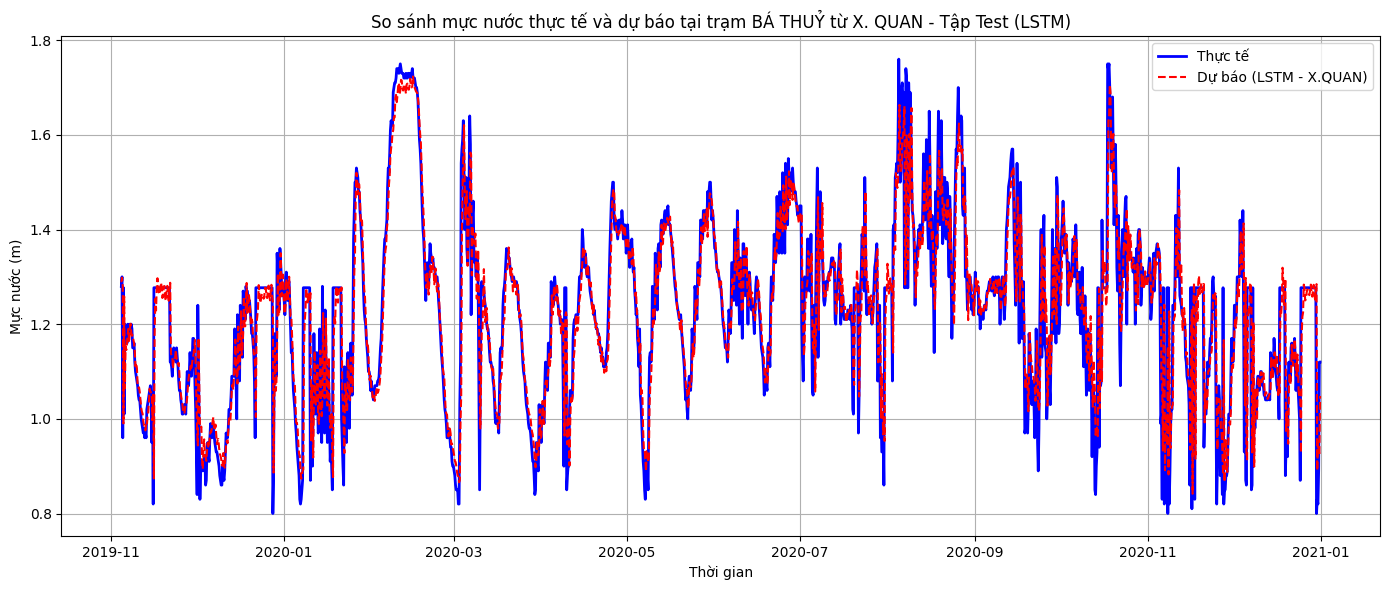

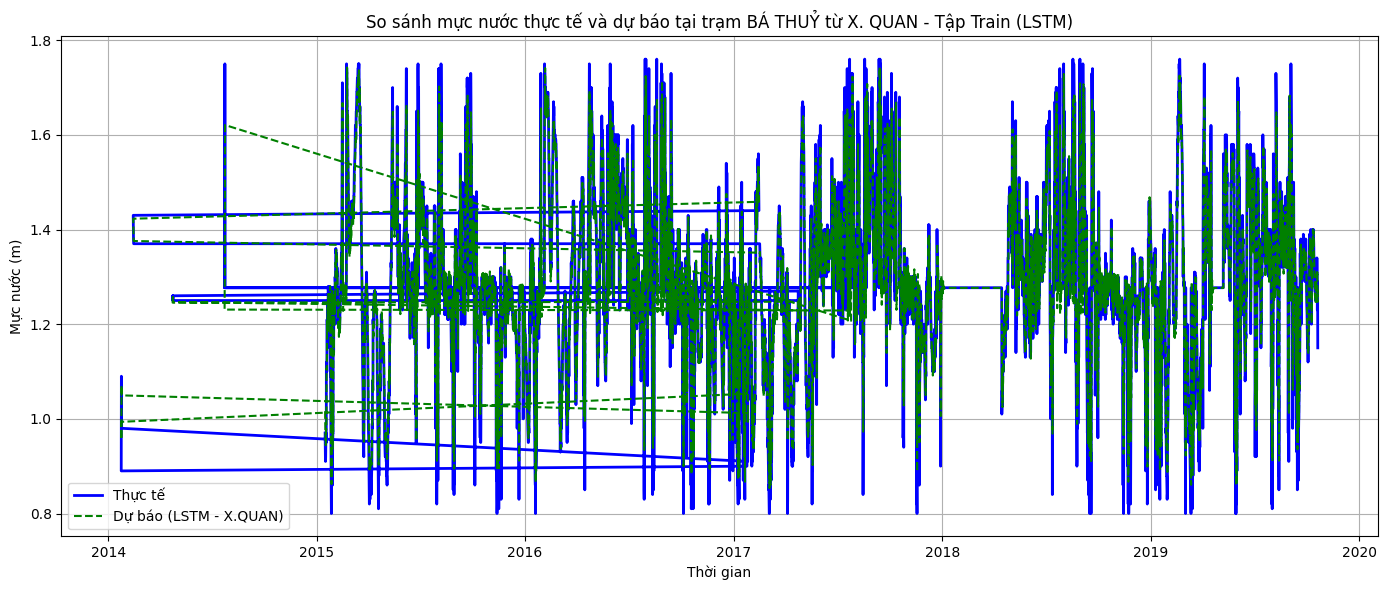

In [2]:
# Dự báo từ X. Quan(3)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.callbacks import EarlyStopping

# 1. Đọc dữ liệu 
df = pd.read_excel("../Data/MN2015_2020_DoAn.xlsx")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)


# 2. Chọn cột X.QUAN làm feature và BÁ THỦY làm target
feature_col = 'X. QUAN'
target_col = 'BÁ THUỶ'
dataset = df[[feature_col, target_col]]

# 3. Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# 4. Chia tập train/test
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size:, :]

# 5. Tạo dataset với time steps
def create_dataset(data, time_steps=60, n_features=2):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, :])  # Lấy cả 2 cột cho input
        y.append(data[i, 1])  # Chỉ lấy cột BÁ THỦY cho output
    return np.array(X), np.array(y)

time_steps = 60
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape dữ liệu cho LSTM
X_train = np.reshape(X_train, (X_train.shape[0], time_steps, 2))
X_test = np.reshape(X_test, (X_test.shape[0], time_steps, 2))

# 6. Xây dựng mô hình LSTM
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(time_steps, 2)),
    LSTM(64, return_sequences=False),
    Dense(32),
    Dense(16),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Thêm EarlyStopping để tránh overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 7. Huấn luyện mô hình
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# 8. Hàm đánh giá mô hình
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# === Dự đoán & đánh giá trên tập TEST ===
predictions = model.predict(X_test)

# Inverse transform
temp_matrix = np.zeros((len(predictions), 2))
temp_matrix[:, 1] = predictions.reshape(-1)
temp_matrix[:, 0] = test_data[time_steps:, 0]
predictions_inv = scaler.inverse_transform(temp_matrix)[:, 1]

y_test_temp = np.zeros((len(y_test), 2))
y_test_temp[:, 1] = y_test
y_test_temp[:, 0] = test_data[time_steps:, 0]
y_test_inv = scaler.inverse_transform(y_test_temp)[:, 1]

# === Dự đoán & đánh giá trên tập TRAIN ===
train_predictions = model.predict(X_train)

temp_train_matrix = np.zeros((len(train_predictions), 2))
temp_train_matrix[:, 1] = train_predictions.reshape(-1)
temp_train_matrix[:, 0] = train_data[time_steps:, 0]
train_predictions_inv = scaler.inverse_transform(temp_train_matrix)[:, 1]

y_train_temp = np.zeros((len(y_train), 2))
y_train_temp[:, 1] = y_train
y_train_temp[:, 0] = train_data[time_steps:, 0]
y_train_inv = scaler.inverse_transform(y_train_temp)[:, 1]

# Đánh giá mô hình 
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

mae, mse, rmse, r2 = evaluate_model(y_test_inv, predictions_inv)
print("\nĐánh giá mô hình trên tập Test")
print(f"Test MAE: {mae:.4f}")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R2 Score: {r2:.4f}")

mae_train, mse_train, rmse_train, r2_train = evaluate_model(y_train_inv, train_predictions_inv)
print("\nĐánh giá mô hình trên tập Train")
print(f"Train MAE: {mae_train:.4f}")
print(f"Train MSE: {mse_train:.4f}")
print(f"Train RMSE: {rmse_train:.4f}")
print(f"Train R2 Score: {r2_train:.4f}")

# Tạo trục thời gian cho tập test
dates_test = df.index[train_size + time_steps:]

plt.figure(figsize=(14, 6))
plt.plot(dates_test, y_test_inv, label='Thực tế', color='blue', linewidth=2)
plt.plot(dates_test, predictions_inv, label='Dự báo (LSTM - X.QUAN)', color='red', linestyle='--')
plt.title('So sánh mực nước thực tế và dự báo tại trạm BÁ THUỶ từ X. QUAN - Tập Test (LSTM)')
plt.xlabel('Thời gian')
plt.ylabel('Mực nước (m)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Tạo trục thời gian cho tập train
dates_train = df.index[time_steps:train_size]

plt.figure(figsize=(14, 6))
plt.plot(dates_train, y_train_inv, label='Thực tế', color='blue', linewidth=2)
plt.plot(dates_train, train_predictions_inv, label='Dự báo (LSTM - X.QUAN)', color='green', linestyle='--')
plt.title('So sánh mực nước thực tế và dự báo tại trạm BÁ THUỶ từ X. QUAN - Tập Train (LSTM)')
plt.xlabel('Thời gian')
plt.ylabel('Mực nước (m)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [32]:
# Gộp dự đoán và thực tế từ train và test
y_full_pred = np.concatenate([train_predictions_inv, predictions_inv])
y_full_true = np.concatenate([y_train_inv, y_test_inv])

# Lấy index đầy đủ (trừ đi `time_steps` vì đó là số mẫu đã bị bỏ qua lúc tạo chuỗi)
index_full = df.index[time_steps:]
index_result = index_full[-len(y_full_pred):]  # đảm bảo độ dài khớp

# Tạo DataFrame kết quả
df_result = pd.DataFrame({
    'Thời gian': index_result,
    'Giá trị thực tế': y_full_true,
    'Giá trị dự đoán': y_full_pred
}).set_index('Thời gian')

# In 10 dòng đầu
print("\nDữ liệu dự báo (Train + Test)")
print(df_result.head())

df_result.to_excel("../Data/du_bao_BA_THUY_LSTM_XQUAN.xlsx")


Dữ liệu dự báo (Train + Test)
                     Giá trị thực tế  Giá trị dự đoán
Thời gian                                            
2015-01-31 01:00:00             0.97         1.033532
2015-01-31 07:00:00             0.93         1.009447
2015-01-31 13:00:00             0.92         0.980543
2015-01-31 19:00:00             0.91         0.964111
2015-02-01 01:00:00             0.92         0.950808
